In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import re
from sklearn.impute import KNNImputer, SimpleImputer
from dataset_processing import get_columns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
# Load dataset
df = pd.read_csv('NHANES_SAMPLE.csv')

# Define target column
target_column, remove_list = get_columns('diab')

# Ensure target column exists
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset!")

# Handle missing target values
df = df.dropna(subset=[target_column])

# Convert target column to binary classification (1 = diabetes, else 0)
df[target_column] = df[target_column].apply(lambda x: 1 if x == 1 else 0)

# Convert all byte-string values to normal strings
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Select all feature columns (excluding target)
feature_columns = [col for col in df.columns if col not in remove_list]
feature_columns = feature_columns +[target_column]
# Define activity columns to combine
df =df[feature_columns]

# Separate categorical and numerical columns
categorical_cols = df[feature_columns].select_dtypes(include=['object']).columns.tolist()
numerical_cols = [col for col in feature_columns if col not in categorical_cols]

# One-hot encode categorical features
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Handle missing values using KNN imputer
knn_imputer = KNNImputer(n_neighbors=3) 
# df.fillna(df.median(), inplace=True)
df = df.dropna(axis=1, how='all')
df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)
df.to_csv("NHANES_SAMPLE_PROCESSED.csv", index=False)


/tmp/ipykernel_2844265/1038230807.py:50: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)


/tmp/ipykernel_2844265/1156730646.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)
Depth=9, working on node 27: 100%|██████████| 28/28 [00:00<00:00, 760.02it/s]


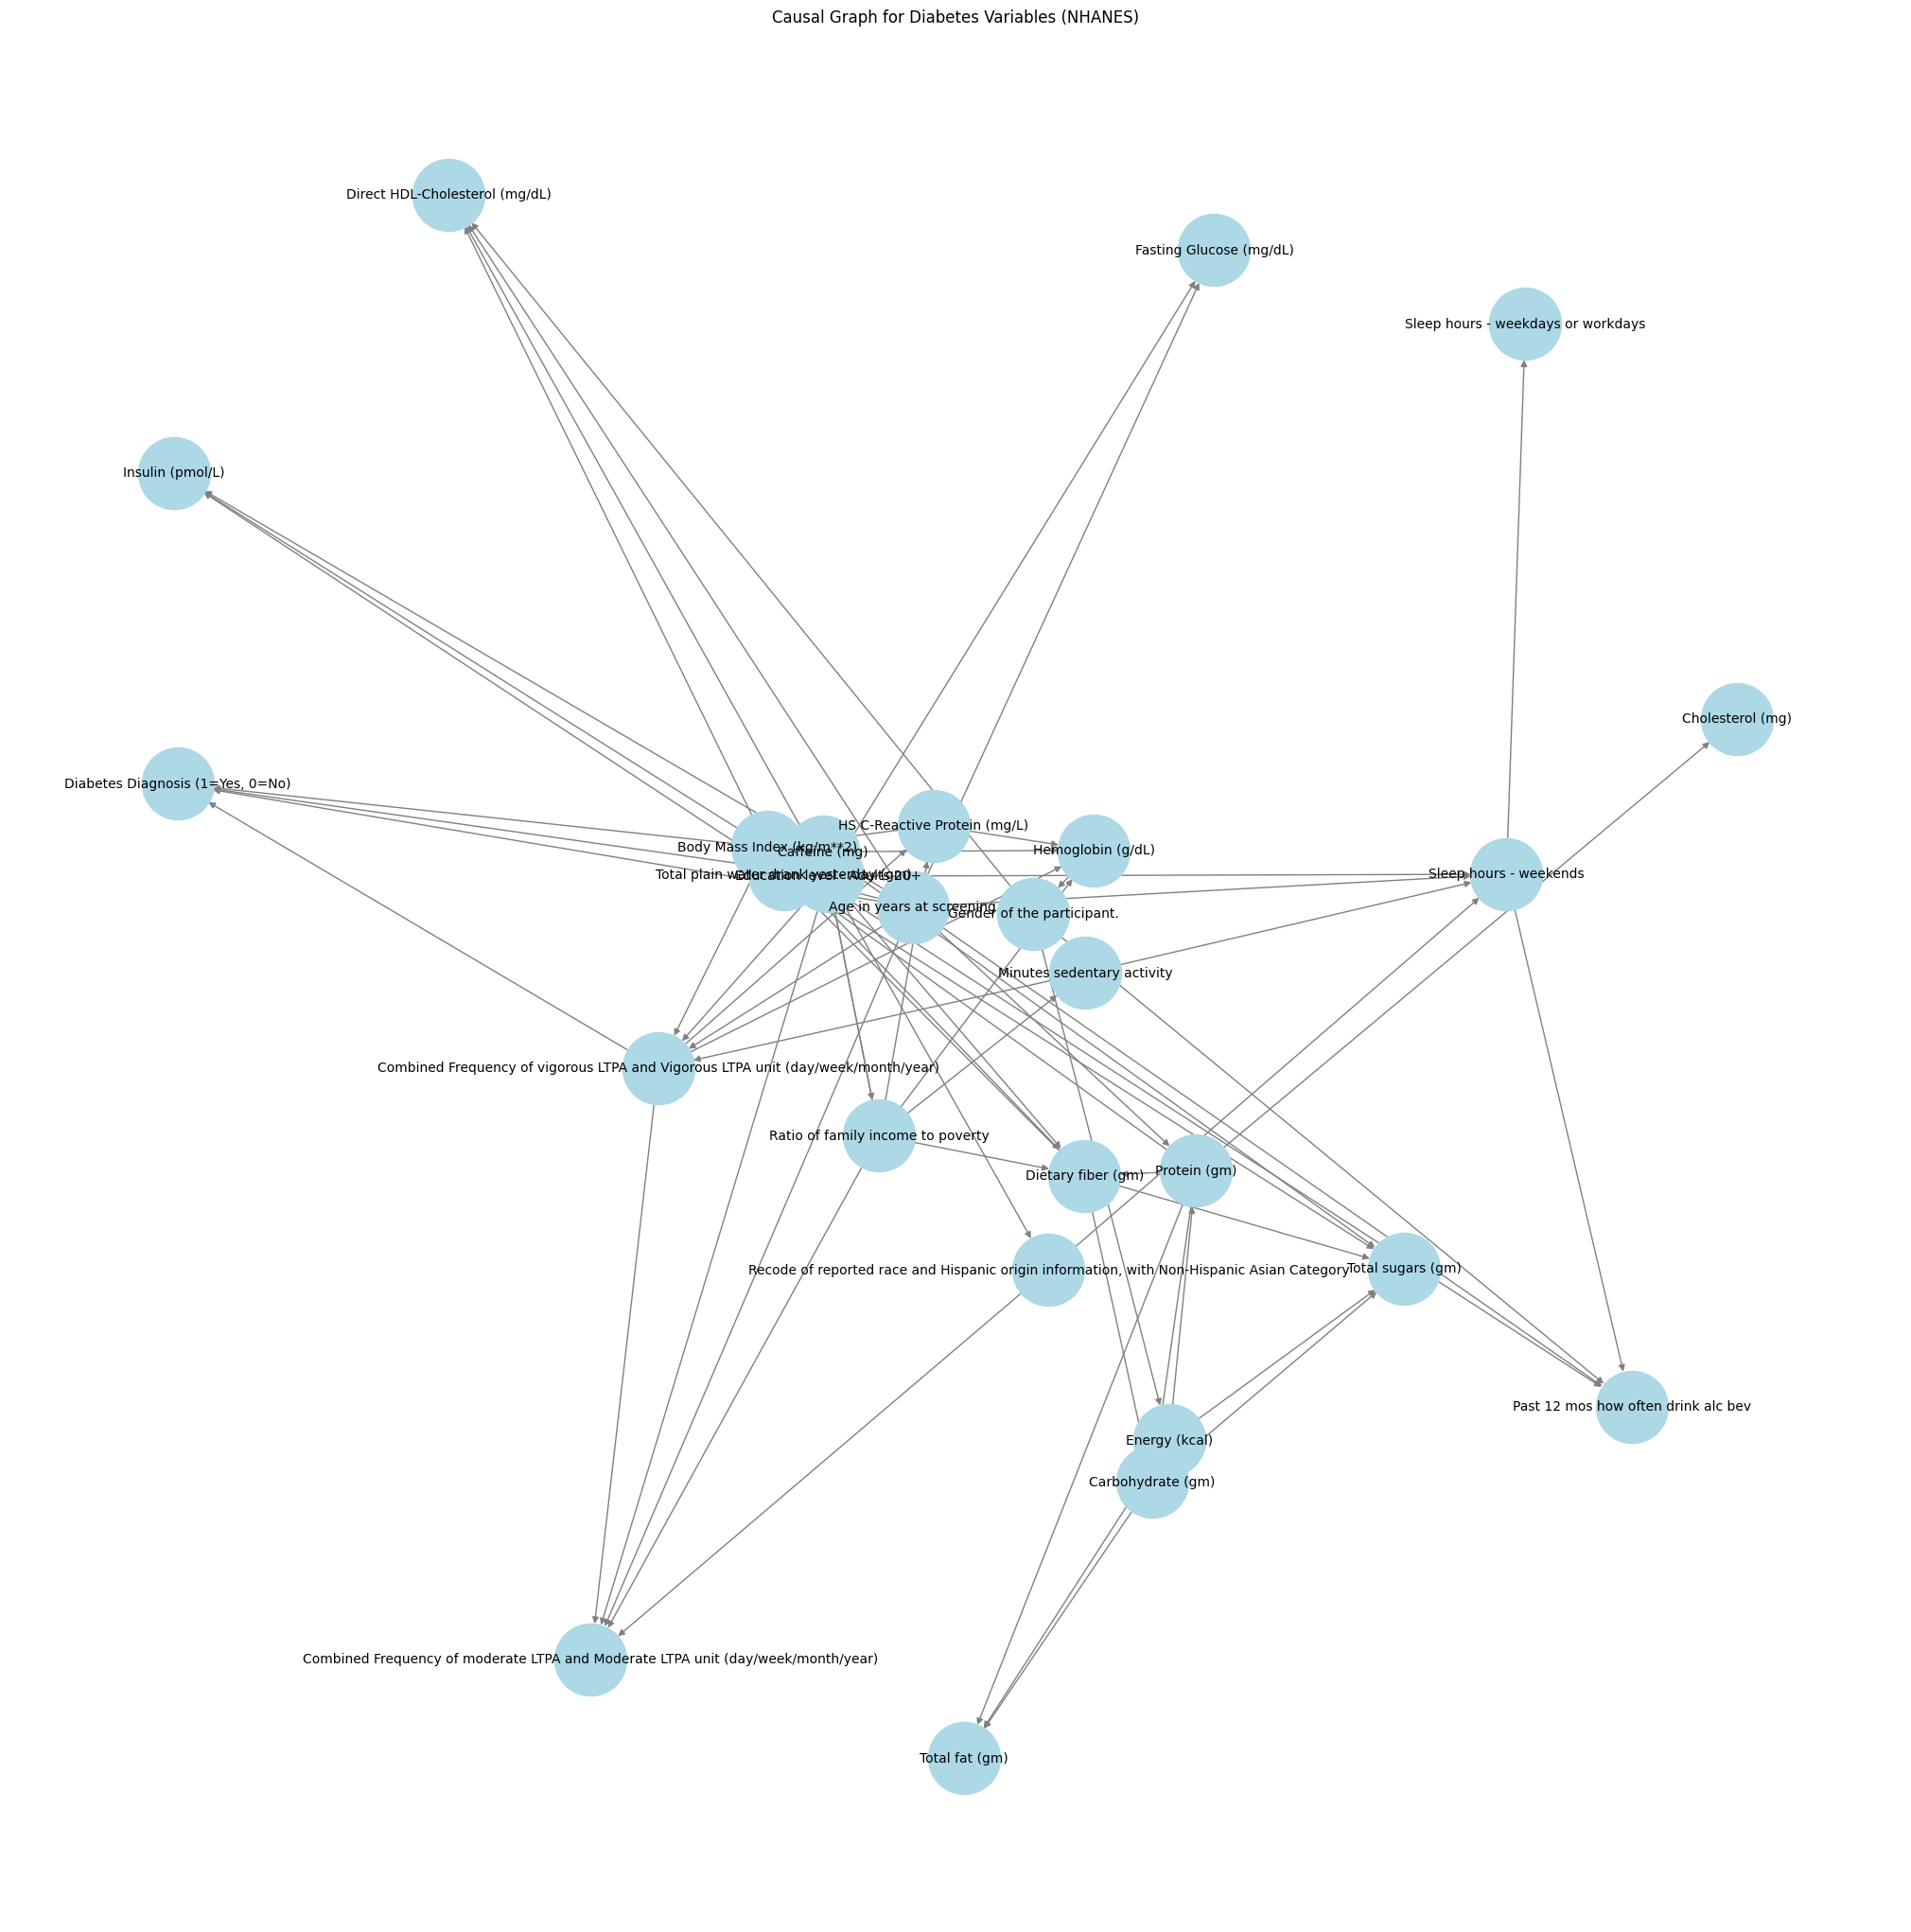

In [57]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz

# Step 1: Load NHANES dataset
df = pd.read_csv("NHANES_SAMPLE.csv")  # Ensure the file path is correct
columns = pd.read_csv("diabetes_short.csv")  # Load diabetes-related variable names and explanations

# Step 2: Keep only selected columns (features + target)
diabetes_vars = columns["column"].tolist() + ["DIQ010"]
df = df[diabetes_vars]

# Step 3: Create a dictionary mapping column names to their explanations
explanation_dict = dict(zip(columns["column"], columns.iloc[:, 1]))  # Column name → Explanation
explanation_dict["DIQ010"] = "Diabetes Diagnosis (1=Yes, 0=No)"  # Manually label the target variable

# Step 4: Convert DIQ010 to binary (1 = diabetes, 0 = non-diabetes)
df["DIQ010"] = df["DIQ010"].apply(lambda x: 1 if x == 1 else 0)

activity_columns = [("PAD790Q", "PAD790U"), ("PAD810Q", "PAD810U")]  # List of pairs

for freq_col, unit_col in activity_columns:
    if freq_col in df.columns and unit_col in df.columns:
        df[f"{freq_col}_combined"] = df[freq_col].astype(str) + "_" + df[unit_col].astype(str)  # Concatenate values
        df.drop([freq_col, unit_col], axis=1, inplace=True)  # Drop original columns
        explanation_dict[f"{freq_col}_combined"] = f"Combined {explanation_dict.get(freq_col, freq_col)} and {explanation_dict.get(unit_col, unit_col)}"


# Step 6: Remove constant columns (if any)
df = df.loc[:, df.nunique() > 1]

# Step 7: Convert categorical columns to numerical
for col in df.select_dtypes(include=["object", "category"]).columns:
    df[col] = df[col].astype("category").cat.codes

# Step 8: Convert dataframe to numpy array

knn_imputer = KNNImputer(n_neighbors=2) 
# df.fillna(df.median(), inplace=True)
df = df.dropna(axis=1, how='all')
df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)

data = df.to_numpy()

# Step 9: Run PC algorithm for causal discovery
cg = pc(data, alpha=0.05, indep_test=fisherz, max_condition_set=1)

# Step 10: Convert causal graph to NetworkX graph
G = nx.DiGraph()  # Create a directed graph
node_labels = {i: col for i, col in enumerate(df.columns)}  # Map indices to column names

# Extract edges from causal graph
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if cg.G.graph[i, j] == 1:  # If an edge exists
            G.add_edge(node_labels[i], node_labels[j])  # Use feature names

# Step 11: Ensure correct labeling with explanations
label_mapping = {node: explanation_dict.get(node, node) for node in G.nodes()}  # Use explanations

# Step 12: Generate `pos` for visualization
pos = nx.spring_layout(G, seed=42)

# Step 13: Visualize the causal graph with explanations
plt.figure(figsize=(20, 20))
nx.draw(G, pos, labels=label_mapping, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()




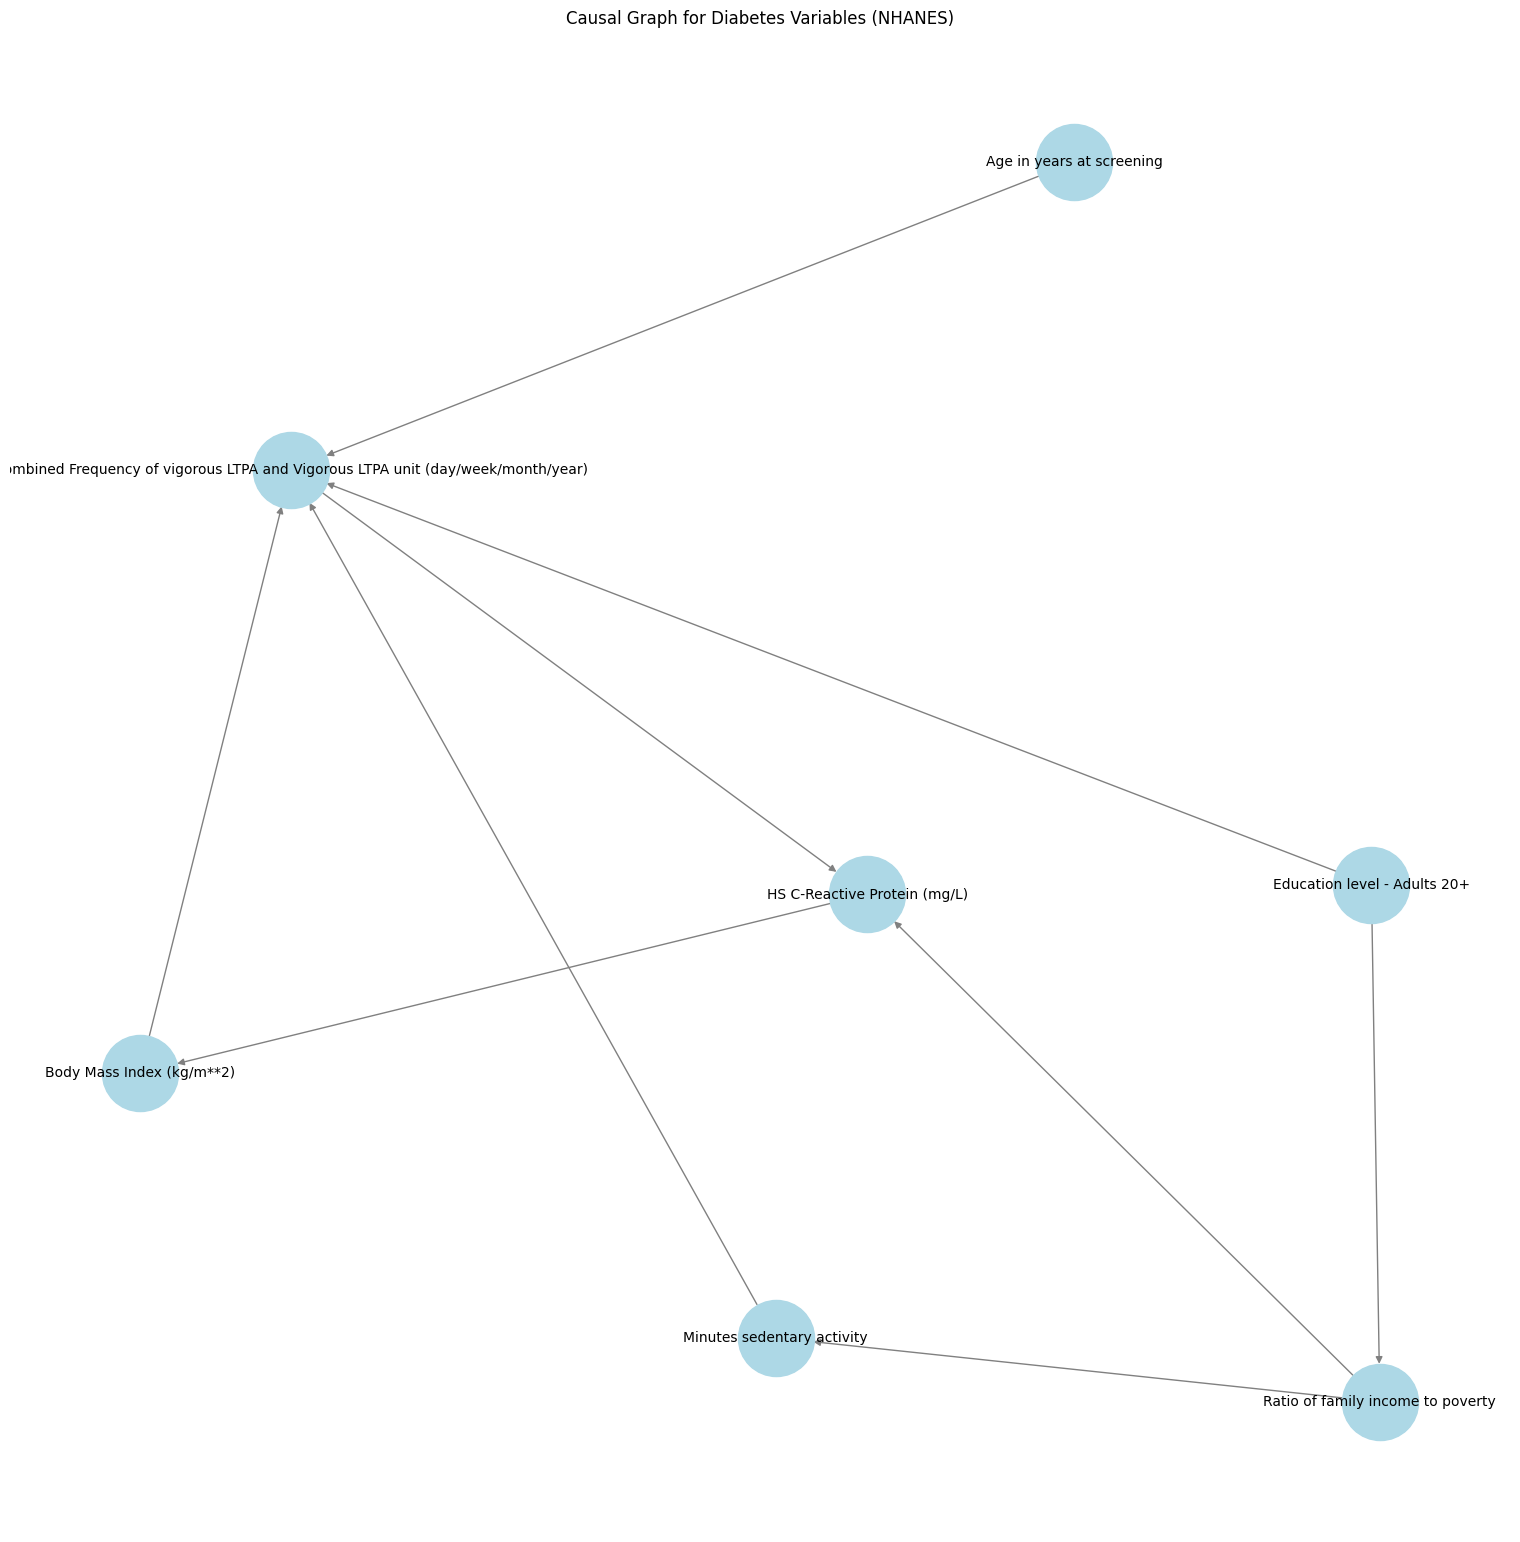

In [59]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Identify all nodes affecting DIQ010
target_var = "BMXBMI"  # Diabetes Diagnosis
affected_nodes = set()  # To store variables that influence diabetes

# Perform a reverse BFS (Backward Search) to find all ancestors of DIQ010
queue = [target_var]

while queue:
    current_node = queue.pop(0)
    affected_nodes.add(current_node)
    
    # Find all parents of the current node (nodes pointing to it)
    for parent in G.predecessors(current_node):
        if parent not in affected_nodes:
            queue.append(parent)

# Step 2: Create a subgraph with only relevant nodes
G_diabetes = G.subgraph(affected_nodes)

# Step 3: Ensure correct labeling with explanations
label_mapping = {node: explanation_dict.get(node, node) for node in G_diabetes.nodes()}

# Step 4: Generate positions for visualization
pos = nx.spring_layout(G_diabetes, seed=42)

# Step 5: Visualize the causal graph
plt.figure(figsize=(15, 15))
nx.draw(G_diabetes, pos, labels=label_mapping, with_labels=True, 
        node_size=3000, node_color="lightblue", edge_color="gray", font_size=10)

plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()


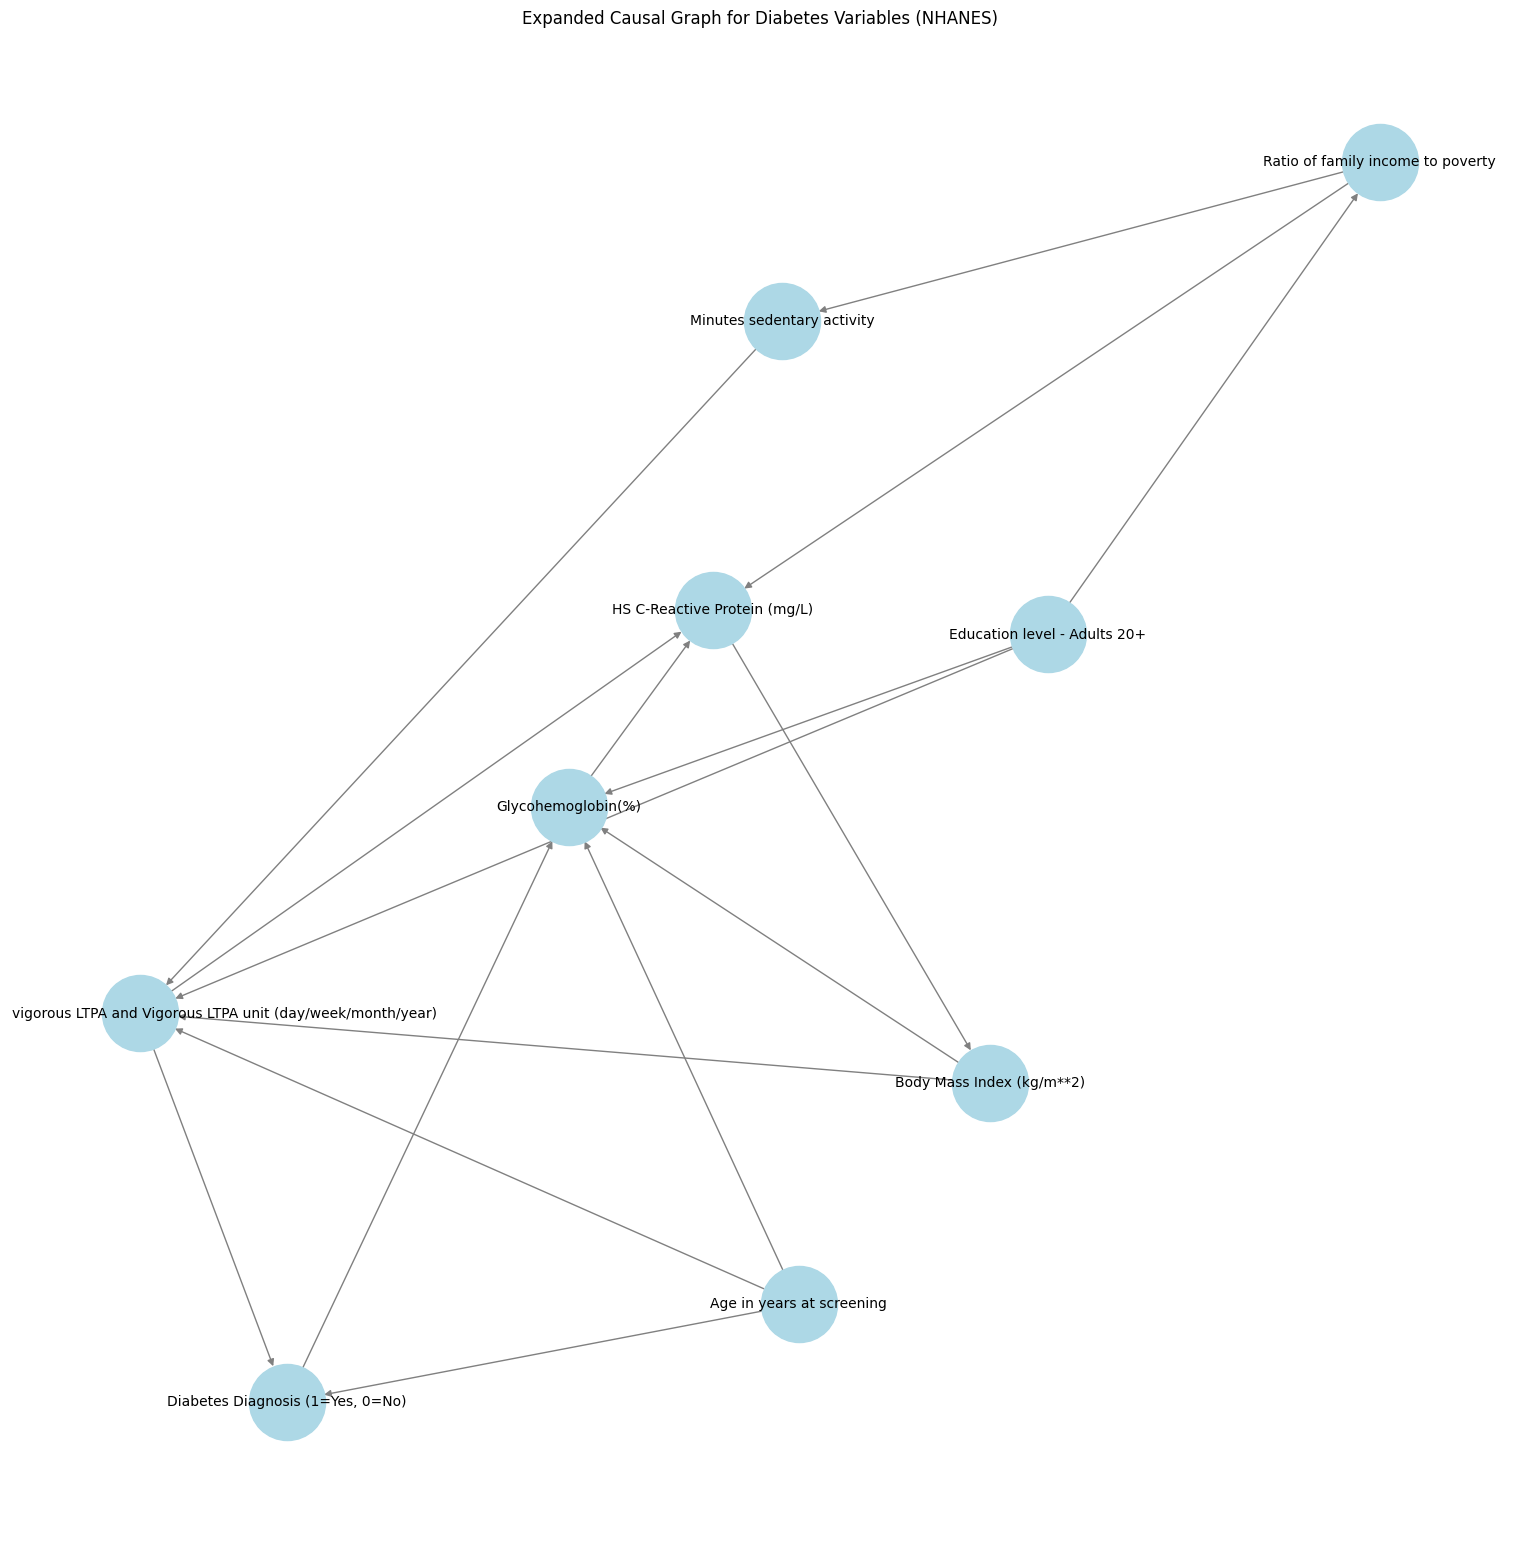

In [28]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Identify all nodes that are ancestors of DIQ010
target_var = "DIQ010"  # Diabetes Diagnosis
affected_nodes = set()  # Store variables that influence diabetes

# Perform a recursive backward search (BFS) to find all ancestors
queue = [target_var]

while queue:
    current_node = queue.pop(0)
    affected_nodes.add(current_node)
    
    # Find all parents (nodes pointing to the current node)
    for parent in G.predecessors(current_node):
        if parent not in affected_nodes:
            queue.append(parent)

# Step 2: Create a subgraph including DIQ010, its parents, and all ancestors
G_diabetes = G.subgraph(affected_nodes)

# Step 3: Ensure correct labeling with explanations
label_mapping = {node: explanation_dict.get(node, node) for node in G_diabetes.nodes()}

# Step 4: Generate positions for visualization
pos = nx.spring_layout(G_diabetes, seed=42)

# Step 5: Visualize the causal graph
plt.figure(figsize=(15, 15))
nx.draw(G_diabetes, pos, labels=label_mapping, with_labels=True, 
        node_size=3000, node_color="lightblue", edge_color="gray", font_size=10)

plt.title("Expanded Causal Graph for Diabetes Variables (NHANES)")
plt.show()


In [60]:
print("\n=== Discovered Causal Relationships ===\n")

for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if cg.G.graph[i, j] == 1:  # If an edge exists
            cause = node_labels[i]
            effect = node_labels[j]
            cause_explained = explanation_dict.get(cause, cause)
            effect_explained = explanation_dict.get(effect, effect)
            print(f"{cause} ({cause_explained}) → {effect} ({effect_explained})")



=== Discovered Causal Relationships ===

RIDAGEYR (Age in years at screening) → DR1TPROT (Protein (gm))
RIDAGEYR (Age in years at screening) → DR1TCAFF (Caffeine (mg))
RIDAGEYR (Age in years at screening) → DR1_320Z (Total plain water drank yesterday (gm))
RIDAGEYR (Age in years at screening) → LBXGLU (Fasting Glucose (mg/dL))
RIDAGEYR (Age in years at screening) → LBDHDD (Direct HDL-Cholesterol (mg/dL))
RIDAGEYR (Age in years at screening) → ALQ121 (Past 12 mos how often drink alc bev)
RIDAGEYR (Age in years at screening) → SLD013 (Sleep hours - weekends)
RIDAGEYR (Age in years at screening) → DIQ010 (Diabetes Diagnosis (1=Yes, 0=No))
RIDAGEYR (Age in years at screening) → PAD790Q_combined (Combined Frequency of moderate LTPA and Moderate LTPA unit (day/week/month/year))
RIDAGEYR (Age in years at screening) → PAD810Q_combined (Combined Frequency of vigorous LTPA and Vigorous LTPA unit (day/week/month/year))
RIAGENDR (Gender of the participant.) → DR1TKCAL (Energy (kcal))
RIAGENDR (Ge

/tmp/ipykernel_2844265/2453076981.py:53: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)
Depth=12, working on node 34: 100%|██████████| 35/35 [00:00<00:00, 910.00it/s]


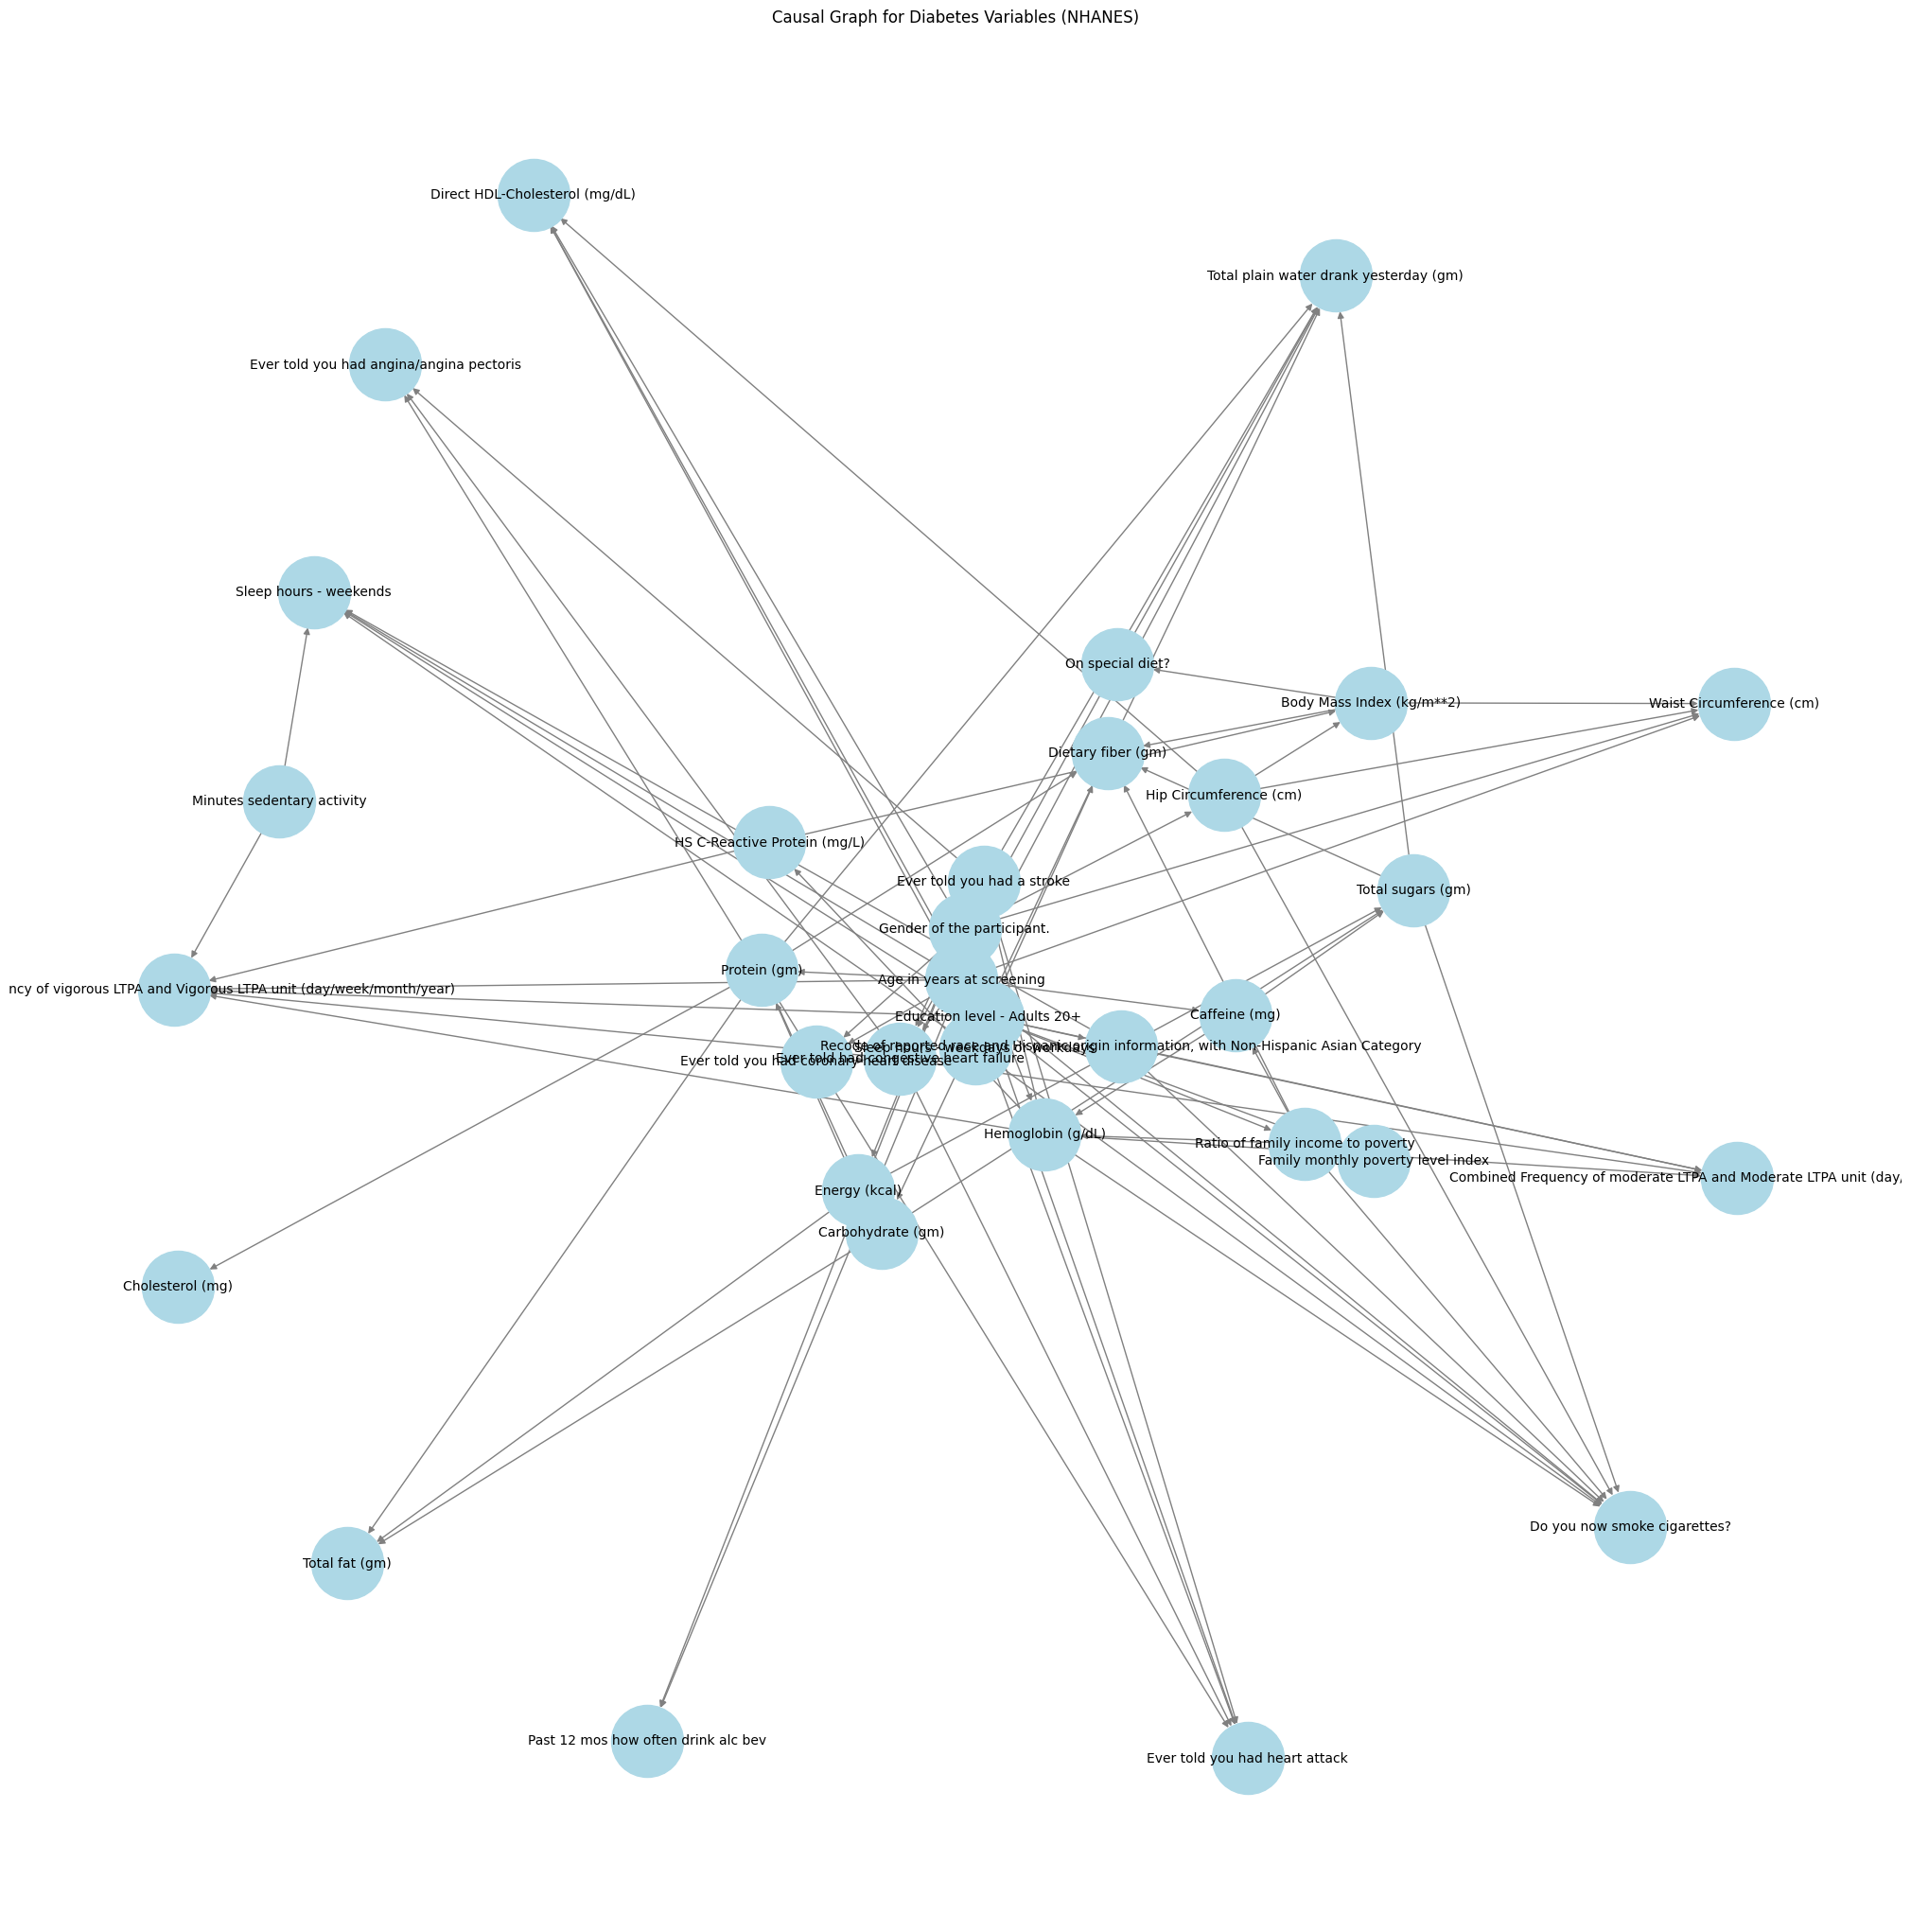

In [45]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz

# Step 1: Load NHANES dataset
df = pd.read_csv("NHANES_SAMPLE.csv")  # Ensure the file path is correct
columns = pd.read_csv("cvd.csv")  # Load diabetes-related variable names and explanations

# Step 2: Keep only selected columns (features + target)
diabetes_vars = columns["column"].tolist()
df = df[diabetes_vars]

# Step 3: Create a dictionary mapping column names to their explanations
explanation_dict = dict(zip(columns["column"], columns.iloc[:, 1]))  # Column name → Explanation
# explanation_dict["DIQ010"] = "Diabetes Diagnosis (1=Yes, 0=No)"  # Manually label the target variable

# # Step 4: Convert DIQ010 to binary (1 = diabetes, 0 = non-diabetes)
# MCQ160B,Ever told had congestive heart failure
# MCQ160D,Ever told you had angina/angina pectoris
# MCQ160E,Ever told you had heart attack
# MCQ160F,Ever told you had a stroke
# MCQ160C,Ever told you had coronary heart disease
df["MCQ160B"] = df["MCQ160B"].apply(lambda x: 1 if x == 1 else 0)
df["MCQ160D"] = df["MCQ160D"].apply(lambda x: 1 if x == 1 else 0)
df["MCQ160E"] = df["MCQ160E"].apply(lambda x: 1 if x == 1 else 0)
df["MCQ160F"] = df["MCQ160F"].apply(lambda x: 1 if x == 1 else 0)
df["MCQ160C"] = df["MCQ160C"].apply(lambda x: 1 if x == 1 else 0)

activity_columns = [("PAD790Q", "PAD790U"), ("PAD810Q", "PAD810U")]  # List of pairs

for freq_col, unit_col in activity_columns:
    if freq_col in df.columns and unit_col in df.columns:
        df[f"{freq_col}_combined"] = df[freq_col].astype(str) + "_" + df[unit_col].astype(str)  # Concatenate values
        df.drop([freq_col, unit_col], axis=1, inplace=True)  # Drop original columns
        explanation_dict[f"{freq_col}_combined"] = f"Combined {explanation_dict.get(freq_col, freq_col)} and {explanation_dict.get(unit_col, unit_col)}"


# Step 6: Remove constant columns (if any)
df = df.loc[:, df.nunique() > 1]

# Step 7: Convert categorical columns to numerical
for col in df.select_dtypes(include=["object", "category"]).columns:
    df[col] = df[col].astype("category").cat.codes

# Step 8: Convert dataframe to numpy array

knn_imputer = KNNImputer(n_neighbors=2) 
# df.fillna(df.median(), inplace=True)
df = df.dropna(axis=1, how='all')
df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)

data = df.to_numpy()

# Step 9: Run PC algorithm for causal discovery
cg = pc(data, alpha=0.05, indep_test=fisherz, max_condition_set=1)

# Step 10: Convert causal graph to NetworkX graph
G = nx.DiGraph()  # Create a directed graph
node_labels = {i: col for i, col in enumerate(df.columns)}  # Map indices to column names

# Extract edges from causal graph
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if cg.G.graph[i, j] == 1:  # If an edge exists
            G.add_edge(node_labels[i], node_labels[j])  # Use feature names

# Step 11: Ensure correct labeling with explanations
label_mapping = {node: explanation_dict.get(node, node) for node in G.nodes()}  # Use explanations

# Step 12: Generate `pos` for visualization
pos = nx.spring_layout(G, seed=42)

# Step 13: Visualize the causal graph with explanations
plt.figure(figsize=(20, 20))
nx.draw(G, pos, labels=label_mapping, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()



In [44]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Identify all nodes that are ancestors of DIQ010
target_var = ['MCQ160B','MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ160C'] # Diabetes Diagnosis
affected_nodes = set()  # Store variables that influence diabetes

# Perform a recursive backward search (BFS) to find all ancestors
queue = target_var

while queue:
    current_node = queue.pop(0)
    affected_nodes.add(current_node)
    
    # Find all parents (nodes pointing to the current node)
    for parent in G.predecessors(current_node):
        if parent not in affected_nodes:
            queue.append(parent)

# Step 2: Create a subgraph including DIQ010, its parents, and all ancestors
G_diabetes = G.subgraph(affected_nodes)

# Step 3: Ensure correct labeling with explanations
label_mapping = {node: explanation_dict.get(node, node) for node in G_diabetes.nodes()}

# Step 4: Generate positions for visualization
pos = nx.spring_layout(G_diabetes, seed=42)

# Step 5: Visualize the causal graph
plt.figure(figsize=(15, 15))
nx.draw(G_diabetes, pos, labels=label_mapping, with_labels=True, 
        node_size=3000, node_color="lightblue", edge_color="gray", font_size=10)

plt.title("Expanded Causal Graph for Diabetes Variables (NHANES)")
plt.show()


NetworkXError: The node MCQ160B is not in the digraph.

In [41]:
print("\n=== Discovered Causal Relationships ===\n")

for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if cg.G.graph[i, j] == 1:  # If an edge exists
            cause = node_labels[i]
            effect = node_labels[j]
            cause_explained = explanation_dict.get(cause, cause)
            effect_explained = explanation_dict.get(effect, effect)
            print(f"{cause} ({cause_explained}) → {effect} ({effect_explained})")



=== Discovered Causal Relationships ===

RIDAGEYR (Age in years at screening) → BMXWAIST (Waist Circumference (cm))
RIDAGEYR (Age in years at screening) → DR1TPROT (Protein (gm))
RIDAGEYR (Age in years at screening) → DR1TCAFF (Caffeine (mg))
RIDAGEYR (Age in years at screening) → DR1_320Z (Total plain water drank yesterday (gm))
RIDAGEYR (Age in years at screening) → LBDHDD (Direct HDL-Cholesterol (mg/dL))
RIDAGEYR (Age in years at screening) → SMQ040 (Do you now smoke cigarettes?)
RIDAGEYR (Age in years at screening) → ALQ121 (Past 12 mos how often drink alc bev)
RIDAGEYR (Age in years at screening) → SLD013 (Sleep hours - weekends)
RIDAGEYR (Age in years at screening) → MCQ160B (Ever told had congestive heart failure)
RIDAGEYR (Age in years at screening) → MCQ160E (Ever told you had heart attack)
RIDAGEYR (Age in years at screening) → MCQ160F (Ever told you had a stroke)
RIDAGEYR (Age in years at screening) → MCQ160C (Ever told you had coronary heart disease)
RIDAGEYR (Age in years

In [52]:
for col in df.columns:
    if "LBXC" in col:
        print(col)

/tmp/ipykernel_2844265/2836665550.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)
Depth=9, working on node 28: 100%|██████████| 29/29 [00:00<00:00, 1029.82it/s]


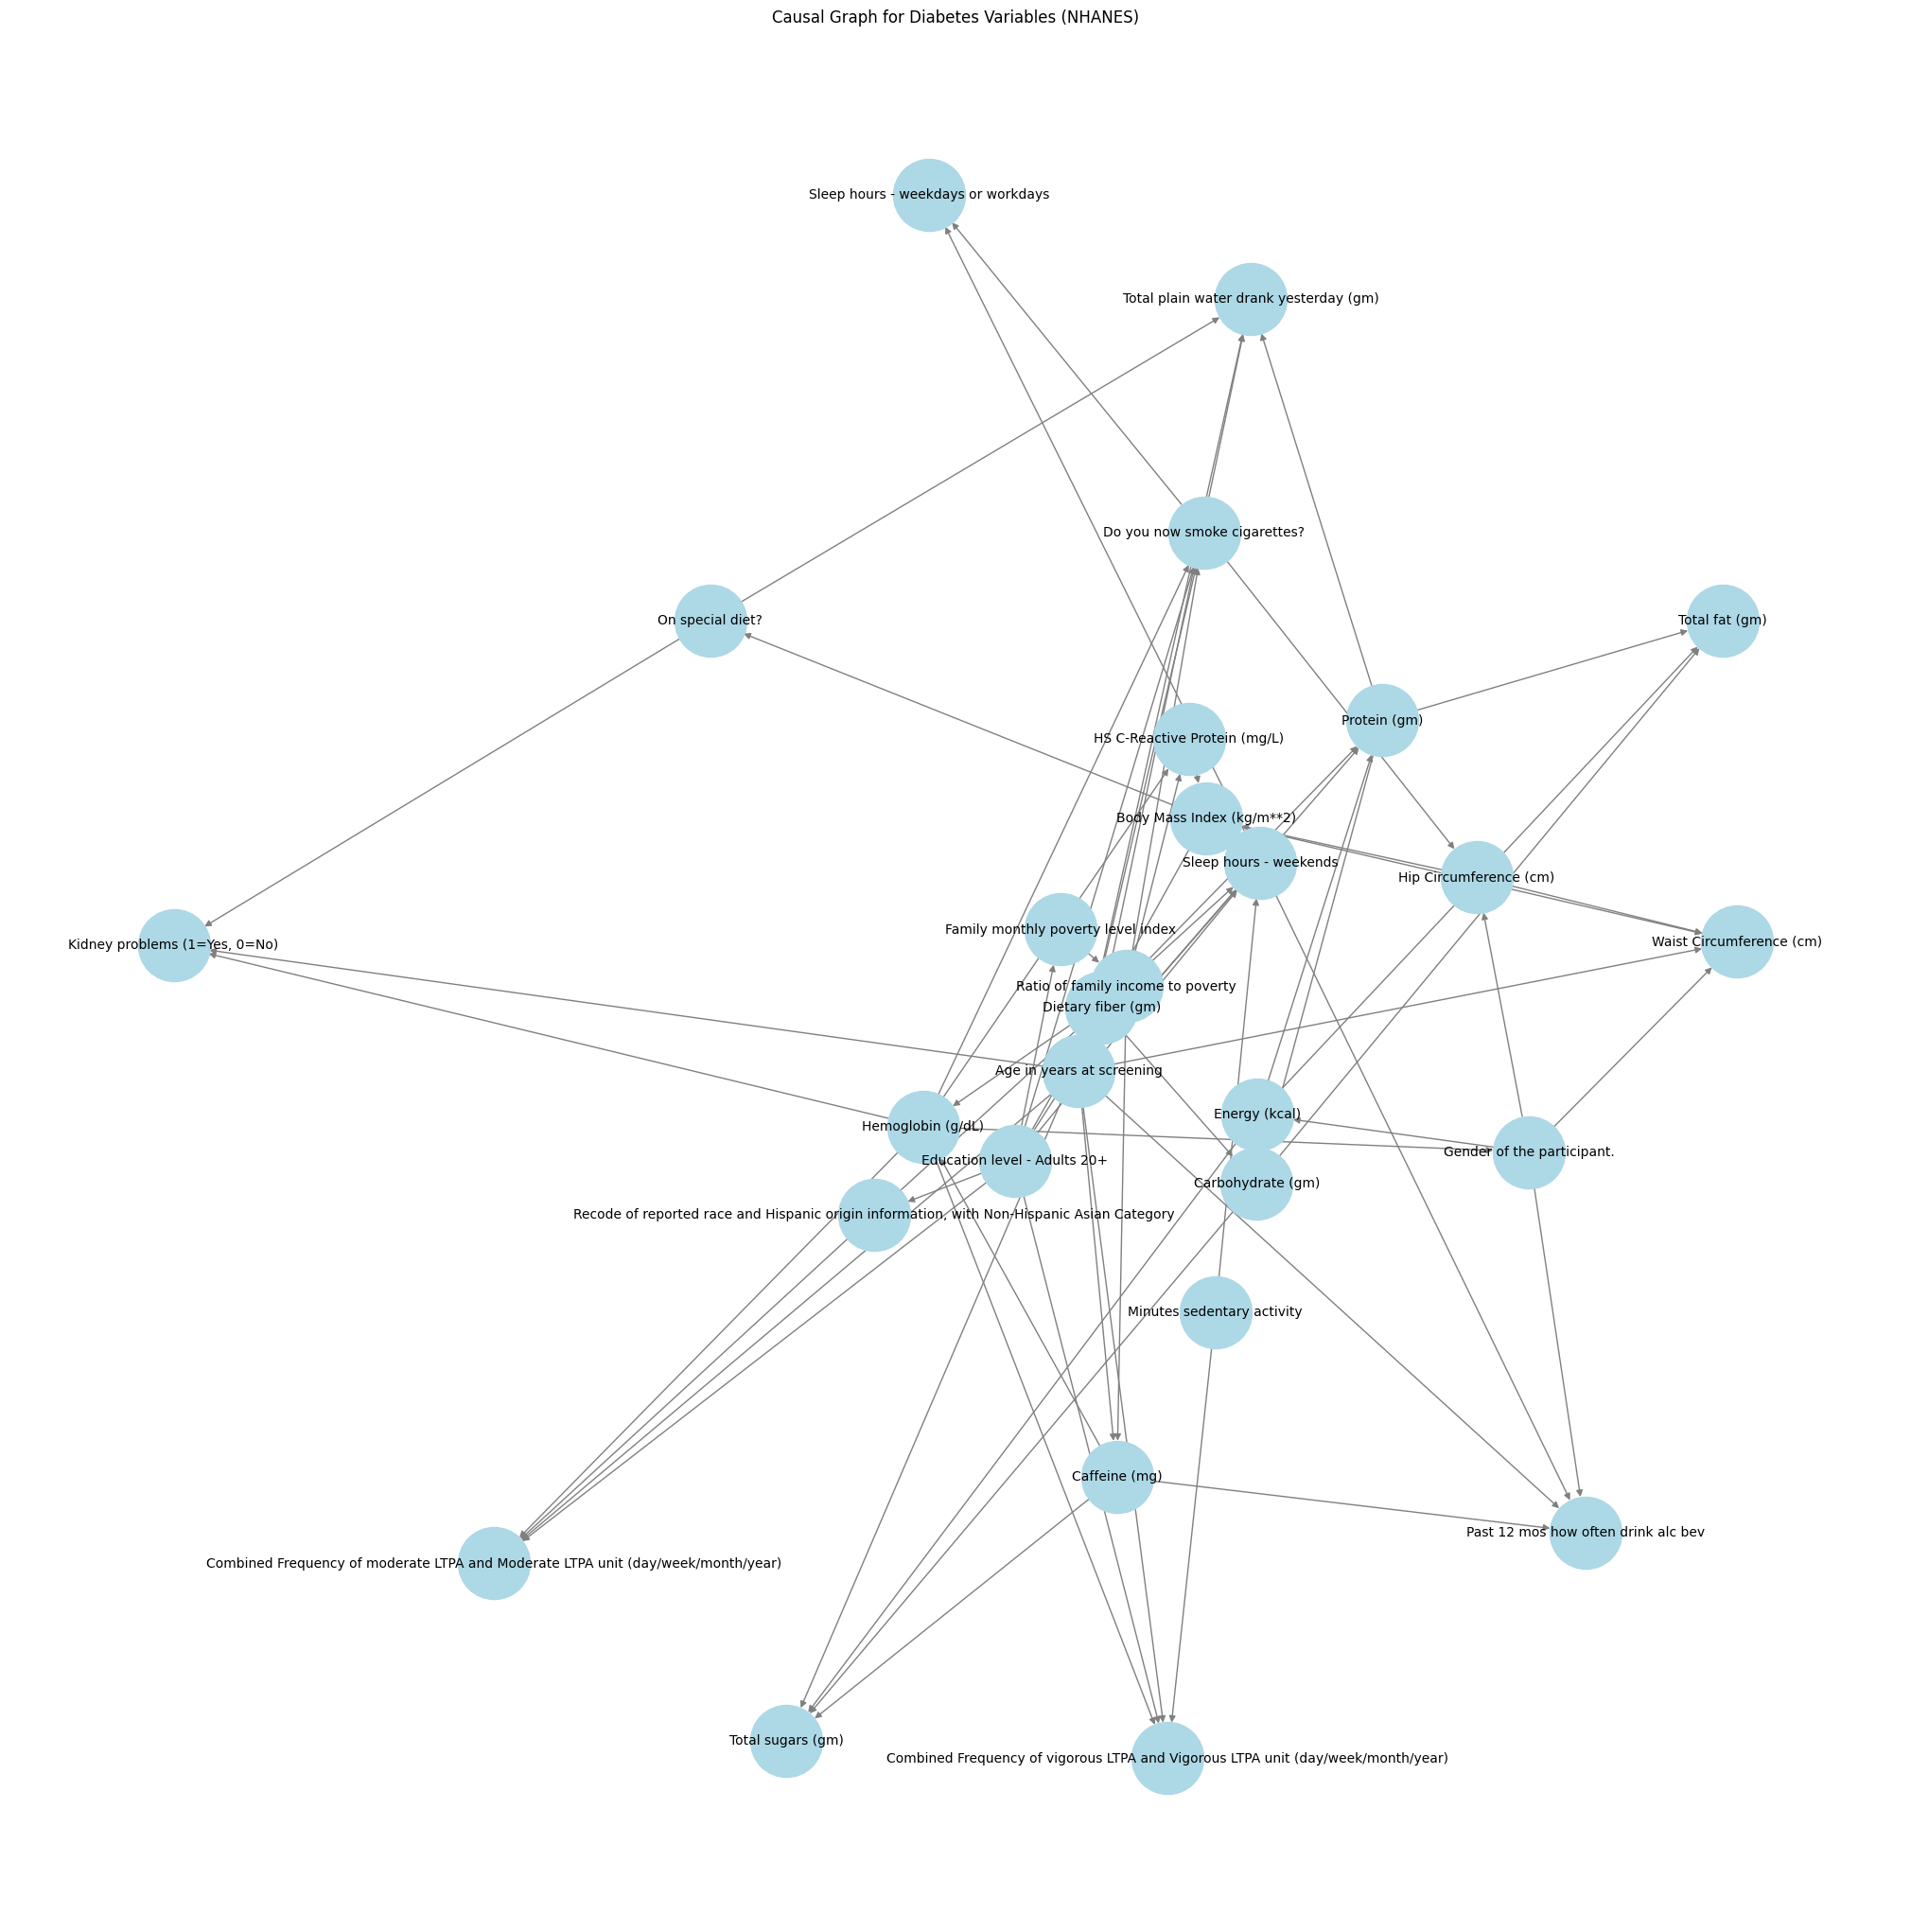

In [53]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz

# Step 1: Load NHANES dataset
df = pd.read_csv("NHANES_SAMPLE.csv")  # Ensure the file path is correct
columns = pd.read_csv("kidney_disease.csv")  # Load diabetes-related variable names and explanations

# Step 2: Keep only selected columns (features + target)
diabetes_vars = columns["column"].tolist() + ["KIQ022"]
df = df[diabetes_vars]

# Step 3: Create a dictionary mapping column names to their explanations
explanation_dict = dict(zip(columns["column"], columns.iloc[:, 1]))  # Column name → Explanation
explanation_dict["KIQ022"] = "Kidney problems (1=Yes, 0=No)"  # Manually label the target variable

# Step 4: Convert DIQ010 to binary (1 = diabetes, 0 = non-diabetes)
df["KIQ022"] = df["KIQ022"].apply(lambda x: 1 if x == 1 else 0)

activity_columns = [("PAD790Q", "PAD790U"), ("PAD810Q", "PAD810U")]  # List of pairs

for freq_col, unit_col in activity_columns:
    if freq_col in df.columns and unit_col in df.columns:
        df[f"{freq_col}_combined"] = df[freq_col].astype(str) + "_" + df[unit_col].astype(str)  # Concatenate values
        df.drop([freq_col, unit_col], axis=1, inplace=True)  # Drop original columns
        explanation_dict[f"{freq_col}_combined"] = f"Combined {explanation_dict.get(freq_col, freq_col)} and {explanation_dict.get(unit_col, unit_col)}"


# Step 6: Remove constant columns (if any)
df = df.loc[:, df.nunique() > 1]

# Step 7: Convert categorical columns to numerical
for col in df.select_dtypes(include=["object", "category"]).columns:
    df[col] = df[col].astype("category").cat.codes

# Step 8: Convert dataframe to numpy array

knn_imputer = KNNImputer(n_neighbors=2) 
# df.fillna(df.median(), inplace=True)
df = df.dropna(axis=1, how='all')
df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)

data = df.to_numpy()

# Step 9: Run PC algorithm for causal discovery
cg = pc(data, alpha=0.05, indep_test=fisherz, max_condition_set=1)

# Step 10: Convert causal graph to NetworkX graph
G = nx.DiGraph()  # Create a directed graph
node_labels = {i: col for i, col in enumerate(df.columns)}  # Map indices to column names

# Extract edges from causal graph
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if cg.G.graph[i, j] == 1:  # If an edge exists
            G.add_edge(node_labels[i], node_labels[j])  # Use feature names

# Step 11: Ensure correct labeling with explanations
label_mapping = {node: explanation_dict.get(node, node) for node in G.nodes()}  # Use explanations

# Step 12: Generate `pos` for visualization
pos = nx.spring_layout(G, seed=42)

# Step 13: Visualize the causal graph with explanations
plt.figure(figsize=(20, 20))
nx.draw(G, pos, labels=label_mapping, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()



In [54]:
print("\n=== Discovered Causal Relationships ===\n")

for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if cg.G.graph[i, j] == 1:  # If an edge exists
            cause = node_labels[i]
            effect = node_labels[j]
            cause_explained = explanation_dict.get(cause, cause)
            effect_explained = explanation_dict.get(effect, effect)
            print(f"{cause} ({cause_explained}) → {effect} ({effect_explained})")



=== Discovered Causal Relationships ===

RIDAGEYR (Age in years at screening) → BMXWAIST (Waist Circumference (cm))
RIDAGEYR (Age in years at screening) → DR1TPROT (Protein (gm))
RIDAGEYR (Age in years at screening) → DR1TCAFF (Caffeine (mg))
RIDAGEYR (Age in years at screening) → DR1_320Z (Total plain water drank yesterday (gm))
RIDAGEYR (Age in years at screening) → SMQ040 (Do you now smoke cigarettes?)
RIDAGEYR (Age in years at screening) → ALQ121 (Past 12 mos how often drink alc bev)
RIDAGEYR (Age in years at screening) → SLD013 (Sleep hours - weekends)
RIDAGEYR (Age in years at screening) → KIQ022 (Kidney problems (1=Yes, 0=No))
RIDAGEYR (Age in years at screening) → PAD790Q_combined (Combined Frequency of moderate LTPA and Moderate LTPA unit (day/week/month/year))
RIDAGEYR (Age in years at screening) → PAD810Q_combined (Combined Frequency of vigorous LTPA and Vigorous LTPA unit (day/week/month/year))
RIAGENDR (Gender of the participant.) → BMXWAIST (Waist Circumference (cm))
RIA